 - 오토 인코더
  - 데이터의 압축과 복원을 하는 목적
  - 입력데이터를 더 낮은 차원으로 압축한후 다시 원래차원으로 복구하는 과정
  - 인코더
  - 디코더
  

In [39]:
# 데이터셋로드 전처리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

- 노이즈 : 데이터에 섞여 정보를 왜곡하는 의도치 않은 정보
- 가우시안 노이즈 : 노이즈 형태가 정규분포형태를 띄는 노이즈
- 오토인코더 : 입력을 그대로 출력하도록 하는 신경망
- CAE : 합성곱을 이용한 오토 인코더

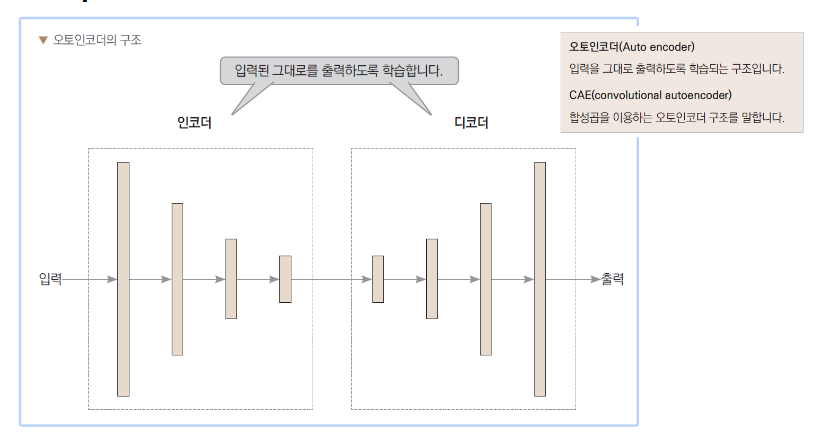

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

In [41]:
# 이미지에 가우스 노이즈를 추가하는 함수
def gaussian_noise(x, scale=0.3):
  gaussian_data_x = x + np.random.normal(
      loc = 0,
      scale = scale,
      size = x.shape
  )
  # 이미지의 픽셀값을 0 ~ 1사이로 정규화
  gaussian_data_x = np.clip(gaussian_data_x,0,1)  # 0보다작으면 0, 1보다 크면 1로 배열의 값을 변경
  # 텐서로 변환
  gaussian_data_x = torch.tensor(gaussian_data_x).type(torch.FloatTensor)
  return gaussian_data_x

<ipython-input-41-f652b48c4272>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x).type(torch.FloatTensor)


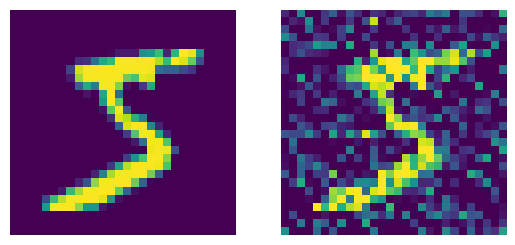

In [42]:
# 학습용 데이터
train_data = MNIST(
  root = './',
  train = True,
  download = True,
  transform = ToTensor()
)
# 평가용 데이터
test_data = MNIST(
  root = './',
  train = False,
  download = True,
  transform = ToTensor()
)
# 원본
img = train_data[0]
# 가우스 노이즈 추가
img_noise = gaussian_noise(img[0])
plt.subplot(1,2,1)
plt.imshow(img[0].permute(1,2,0))
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_noise.permute(1,2,0))
plt.axis('off')
plt.show()

In [43]:
tensor_1 = torch.tensor([1,2,3])
print(tensor_1.shape)
tensor_1_2dim = torch.unsqueeze(tensor_1,dim=-1)
print(tensor_1_2dim.shape)
tensor_1_1d = torch.squeeze(tensor_1_2dim)
print(tensor_1_1d.shape)

torch.Size([3])
torch.Size([3, 1])
torch.Size([3])


In [44]:
# 데이터에 노이즈 삽입한 데이터셋
from torch.utils.data import Dataset
class GaussianNoiseDataset(Dataset):
  def __init__(self):
    self.mnist = MNIST(
      root = './',
      train = True,
      download = True,
      transform = ToTensor()
    )
    self.data = []  # 데이터에 노이즈 입히기
    for i in range(len(self.mnist)):
      img_noise = gaussian_noise(self.mnist.data[i])
      input_tensor = torch.tensor(img_noise)
      self.data.append(torch.unsqueeze(input_tensor,dim=0))

  def __len__(self):
    return len(self.mnist)
  def __getitem__(self,idx):
    data = self.data[idx]
    label = self.mnist[idx][1]
    return data, label

 - 인코더
  -  기본블럭
    - c-c
  - 기본블럭-폴링-기본블럭-폴링

In [45]:
# 베이직 블럭
class BasicBlock(torch.nn.Module):
  def __init__(self,in_channels,out_channels,hidden_dim):
    super(BasicBlock,self).__init__()
    self.conv1 = torch.nn.Conv2d(
      in_channels = in_channels,
      out_channels = hidden_dim,
      kernel_size = 3,
      padding = 1
    )
    self.conv2 = torch.nn.Conv2d(
      in_channels = hidden_dim,
      out_channels = out_channels,
      kernel_size = 3,
      padding = 1
    )
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    return x


In [46]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder,self).__init__()
    self.conv1 = BasicBlock(in_channels=1,out_channels=8,hidden_dim=8)
    self.conv2 = BasicBlock(in_channels=8,out_channels=8,hidden_dim=16)
    self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
  def forward(self,x):
    x = self.pool(self.conv1(x))
    x = self.pool(self.conv2(x))
    return x


- upsample
  - convolution의 반대 개념

In [53]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder,self).__init__()
    self.conv1= BasicBlock(in_channels=8,out_channels=8,hidden_dim=8)
    self.conv2= BasicBlock(in_channels=8,out_channels=16,hidden_dim=16)
    # 출력층은 기본블럭이 아니라 conv 층
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels=1, kernel_size=3, padding=1)
    self.upsample1 = nn.ConvTranspose2d(8,8,kernel_size=2,stride=2)
    self.upsample2 = nn.ConvTranspose2d(16,16,kernel_size=2,stride=2)
  # 인코더의 폴링 대신 입력 크기를 키우는 업셈플밍 이용
  def forward(self,x):
    x = self.conv1(x)
    x = self.upsample1(x)
    x = self.conv2(x)
    x = self.upsample2(x)
    x = self.conv3(x)
    return x

In [54]:
# CAE
class CAE(nn.Module):
  def __init__(self):
    super(CAE,self).__init__()

    self.encoder = Encoder()
    self.decoder = Decoder()
  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)
    # MNIST는 채널정보가 없음 제거
    x = torch.squeeze(x)
    return x

In [ ]:
# 모델 학습
import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim import Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trainset = GaussianNoiseDataset()
train_loader = DataLoader(
    trainset,batch_size=32)
model = CAE().to(device)
optimizer = Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()  # 이미지의 각 픽셀의 값을 예측  회귀
for epoch in range(20):
  iterator = tqdm.tqdm(train_loader)
  for data,label in iterator:
    optimizer.zero_grad()
    data = data.to(device)
    label = label.to(device)
    pred = model(data)  # conv 태웠기 때문에.. 채널정보가 있음

    loss = criterion(torch.squeeze(pred),data)  # 오리지널은 채널정보가 없음
    loss.backward()  # 미분값을 구함
    optimizer.step() # 적용
    iterator.set_description(f'epoch:{epoch+1} loss:{loss.item()}')
torch.save(model.state_dict(),'./CAE.pth')

<ipython-input-41-f652b48c4272>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x).type(torch.FloatTensor)
<ipython-input-44-7583f2c2a97c>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(img_noise)
  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([32, 1, 28, 28])) that is different to the input size (torch.Size([32, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch:1 loss:0.10678